# User Workload

The workload is designed to simulate and manage the demand created by users requesting text summarization and translation services. It combines the concepts of user simulation, queuing, and workload management. The purpose is to efficiently handle user requests, adapt to varying levels of demand, and dynamically allocate resources (nodes) based on the system's load. It ensures that the processing time for each request remains within acceptable limits by scaling up or down the number of active servers. Additionally, it simulates real-world scenarios where users arrive at different times and request summaries in multiple languages.

In [ ]:
import numpy as np
import pandas as pd
import torch
import queue
import time
import threading
import random
import contextlib
import os
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm
from transformers import T5Tokenizer, T5ForConditionalGeneration, M2M100ForConditionalGeneration, M2M100Tokenizer
from google.colab import drive
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
drive.mount('/content/drive', force_remount=True)

file_path = '/content/drive/My Drive/Multilingual Text Summarization Service/cleaned_dataset.csv'
data = pd.read_csv(file_path)

articles = data['article'].tolist()
highlights = data['highlights'].tolist()
print("Dataset loaded successfully.")

Mounted at /content/drive
Dataset loaded successfully.


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def load_t5_model(model_name):
    tokenizer = T5Tokenizer.from_pretrained(model_name)
    model = T5ForConditionalGeneration.from_pretrained(model_name).to(device)
    return tokenizer, model

m2m_tokenizer = M2M100Tokenizer.from_pretrained("facebook/m2m100_418M")
m2m_model = M2M100ForConditionalGeneration.from_pretrained("facebook/m2m100_418M").to(device)

print("Models and tokenizers loaded successfully.")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/298 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/3.71M [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/1.14k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/908 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.94G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/233 [00:00<?, ?B/s]

Models and tokenizers loaded successfully.


In [ ]:
class SummarizationService:
    def __init__(self, m2m_tokenizer, m2m_model, device):
        """
        Initialize the summarization service.
        """
        self.m2m_tokenizer = m2m_tokenizer
        self.m2m_model = m2m_model
        self.device = device
        self.current_t5_model = None
        self.t5_tokenizer = None
        self.t5_model = None

    def summarize_english(self, article_text, num_beams=8, length_penalty=1.0, model_name="t5-base"):
        """
        Summarize an article in English with adjustable quality parameters.
        Dynamically load the T5 model if not already loaded.
        """
        if self.current_t5_model != model_name:
            print(f"Switching to T5 model: {model_name}")
            self.t5_tokenizer, self.t5_model = load_t5_model(model_name)
            self.current_t5_model = model_name

        input_ids = self.t5_tokenizer.encode(article_text, return_tensors="pt", max_length=512, truncation=True).to(self.device)

        summary_ids = self.t5_model.generate(
            input_ids,
            num_beams=num_beams,
            length_penalty=length_penalty,
            max_length=512,
            early_stopping=True
        )

        return self.t5_tokenizer.decode(summary_ids[0], skip_special_tokens=True)

    def translate_with_m2m(self, article_text, target_lang, num_beams=8, length_penalty=1.0, model_name="t5-base"):
        """
        Summarize an article in English and translate it to the target language.
        Dynamically load the T5 model if not already loaded.
        """
        summary = self.summarize_english(article_text, num_beams, length_penalty, model_name)

        self.m2m_tokenizer.src_lang = "en"
        input_ids = self.m2m_tokenizer(summary, return_tensors="pt", truncation=True, max_length=512).to(self.device)

        translated_tokens = self.m2m_model.generate(
            input_ids["input_ids"],
            forced_bos_token_id=self.m2m_tokenizer.lang_code_to_id[target_lang],
            num_beams=num_beams,
            early_stopping=True
        )

        return self.m2m_tokenizer.decode(translated_tokens[0], skip_special_tokens=True)

In [ ]:
QUALITY_CONFIG = {
    "high": {
        "num_beams": 2,
        "length_penalty": 0.5,
        "model_name": "t5-small"
    },
    "medium": {
        "num_beams": 3,
        "length_penalty": 1.0,
        "model_name": "t5-small"
    },
    "low": {
        "num_beams": 4,
        "length_penalty": 1.5,
        "model_name": "t5-base"
    }
}

In [ ]:
class QueuingManager:
    def __init__(self, service, max_nodes=3, optimization_disabled=False):
        """
        Initialize the queuing manager.
        - service: The summarization service instance.
        - max_nodes: Maximum number of server nodes.
        """
        self.service = service
        self.max_nodes = max_nodes
        self.jobs_queue = queue.Queue()
        self.current_nodes = 1
        self.available_languages = ["en", "fr", "de", "uk", "sq"]
        self.quality_settings = QUALITY_CONFIG
        self.optimization_disabled = optimization_disabled

    def get_workload_level(self):
        """
        Determine the current workload level based on the queue size.
        """
        queue_size = self.jobs_queue.qsize()
        if queue_size > 5:
            return "high"
        elif queue_size > 3:
            return "medium"
        else:
            return "low"

    def get_quality_parameters(self):
        """
        Get generation parameters based on the current workload.
        """
        if self.optimization_disabled:
          # Return high-quality settings regardless of workload
          return self.quality_settings.get("low", {})

        workload_level = self.get_workload_level()
        return self.quality_settings.get(workload_level, {})

    def log_queue_info(self):
        """
        Log the current queue statistics.
        """
        queue_size = self.jobs_queue.qsize()
        workload_level = self.get_workload_level()
        print(f"\n[Queue Info] Current Queue Size: {queue_size}, Workload Level: {workload_level}, Active Nodes: {self.current_nodes}")

    def process_request(self, request):
        """
        Process a single request from the queue.
        - request: Dictionary containing user request data (id, language, article_text).
        """
        start_time = time.time()
        article_text = request["article_text"]
        target_lang_code = request["language"]

        available_languages = request["available_languages_at_request"]
        if target_lang_code not in available_languages:
            print(f"[Request Skipped] Language {target_lang_code} was not available at the time of the request.")
            return {"id": request["id"], "language": target_lang_code, "summary": None, "processing_time": None}

        quality_params = self.get_quality_parameters()
        model_name = quality_params["model_name"]

        if target_lang_code == "en":
            summary = self.service.summarize_english(
                article_text,
                num_beams=quality_params["num_beams"],
                length_penalty=quality_params["length_penalty"],
                model_name=model_name
            )
        else:
            summary = self.service.translate_with_m2m(
                article_text,
                target_lang=target_lang_code,
                num_beams=quality_params["num_beams"],
                length_penalty=quality_params["length_penalty"],
                model_name=model_name
            )

        end_time = time.time()
        processing_time = end_time - start_time

        print(f"Processed Article for {target_lang_code.upper()}: {summary}")

        return {
            "id": request["id"],
            "language": target_lang_code,
            "summary": summary,
            "start_time": start_time,
            "end_time": end_time,
            "processing_time": processing_time
        }

    def adjust_node_count_and_languages(self):
        """
        Adjust the number of active nodes dynamically based on the workload level
        and optimize the available languages.
        """
        workload_level = self.get_workload_level()

        if workload_level == "high":
            self.available_languages = ["en"]
            print(f"[Language Adjustment] High workload: Available languages reduced to: {self.available_languages}")
        elif workload_level == "medium":
            self.available_languages = ["en", "de", "sq"]
            print(f"[Language Adjustment] Medium workload: Available languages reduced to: {self.available_languages}")
        else:
            self.available_languages = ["en", "fr", "de",  "uk", "sq"]
            print(f"[Language Adjustment] Low workload: All languages are available.")

        if workload_level == "high" and self.current_nodes < self.max_nodes:
            self.current_nodes += 1
            print(f"[Node Adjustment] Increased nodes to {self.current_nodes}.")
        elif workload_level == "low" and self.current_nodes > 1:
            self.current_nodes -= 1
            print(f"[Node Adjustment] Decreased nodes to {self.current_nodes}.")

    def run_simulation(self, log_data):
        """
        Run the queuing manager simulation, processing all jobs in the queue.
        Ensures strict FIFO order: First In, First Out.
        """
        try:
            end_signal_received = False
            progress = tqdm(desc="Processing requests", leave=False)

            while not self.jobs_queue.empty() or not end_signal_received:
                queue_size = self.jobs_queue.qsize()
                active_nodes = self.current_nodes
                log_data.append({"queue_size": queue_size, "active_nodes": active_nodes, "time": time.time()})

                self.adjust_node_count_and_languages()
                request = self.jobs_queue.get()

                if request is None:
                    end_signal_received = True
                    continue

                result = self.process_request(request)

                if result is not None:
                    progress.update(1)
                    log_data[-1]["processing_time"] = result["processing_time"]
                    print(
                        f"\n[Processed Request] ID: {result['id']}, Language: {result['language']}, "
                        f"Summary: {result['summary']}, Processing Time: {result['processing_time']:.2f} seconds"
                    )

            progress.close()
            print("\n[Simulation Complete] All requests processed.")
        except Exception as e:
            print(f"Error occurred during simulation: {e}")

    def get_current_available_languages(self):
        """
        Return the list of currently available languages based on workload level.
        """
        self.adjust_node_count_and_languages()
        return self.available_languages

In [ ]:
class UserSimulation:
    def __init__(self, n_users, queuing_manager, articles):
        """
        Initialize the user simulation.
        - n_users: Number of users to simulate.
        - queuing_manager: Instance of the QueuingManager.
        - articles: List of article texts.
        """
        self.n_users = n_users
        self.languages = ["en", "fr", "de", "uk", "sq"]
        self.queuing_manager = queuing_manager
        self.articles = articles

    def simulate_users(self, inter_arrival_rate=0.1):
        """
        Simulate user requests arriving gradually based on inter-arrival times.
        - inter_arrival_rate: Rate of user arrival (exponential distribution).
        """
        rng = np.random.default_rng(seed=42)
        inter_arrival_times = rng.exponential(scale=inter_arrival_rate, size=self.n_users)

        print("[Simulation Start] Users are arriving...")

        for i in range(self.n_users):
            available_languages = self.queuing_manager.get_current_available_languages()

            if not available_languages:
                print("[No Available Languages] Skipping user generation.")
                continue

            chosen_language = random.choice(available_languages)
            article_text = random.choice(self.articles)

            request = {
                "id": i,
                "language": chosen_language,
                "article_text": article_text,
                "available_languages_at_request": available_languages
            }

            self.queuing_manager.jobs_queue.put(request)

            print(f"[User Arrival] User {i} arrived requesting language: {request['language']}.")
            time.sleep(inter_arrival_times[i])

        print("[Simulation Complete] All users have arrived.")


In [ ]:
results_folder = "/content/drive/My Drive/Multilingual Text Summarization Service/optimization_results"
os.makedirs(results_folder, exist_ok=True)

def disable_optimization(queuing_manager):
    queuing_manager.optimization_disabled = True
    def no_adjustment():
        pass
    queuing_manager.adjust_node_count_and_languages = no_adjustment

def run_experiment(save_path, before_optimization=False):
    summarization_service = SummarizationService(m2m_tokenizer, m2m_model, device)
    log_data = []
    queuing_manager = QueuingManager(service=summarization_service)
    simulation = UserSimulation(n_users=10, queuing_manager=queuing_manager, articles=articles)

    if before_optimization:
        disable_optimization(queuing_manager)

    queuing_thread = threading.Thread(target=queuing_manager.run_simulation, args=(log_data,))
    queuing_thread.start()
    simulation.simulate_users(inter_arrival_rate=0.5)
    queuing_manager.jobs_queue.put(None)
    queuing_thread.join()

    df = pd.DataFrame(log_data)
    df.to_csv(save_path, index=False)
    print(f"Results saved to {save_path}")

print("Running Before Optimization...")
before_optimization_path = os.path.join(results_folder, "before_optimization.csv")
run_experiment(before_optimization_path, before_optimization=True)

print("\nRunning After Optimization...")
after_optimization_path = os.path.join(results_folder, "after_optimization.csv")
run_experiment(after_optimization_path)

Running Before Optimization...
[Simulation Start] Users are arriving...
[User Arrival] User 0 arrived requesting language: en.



Processing requests: 0it [00:00, ?it/s]

Switching to T5 model: t5-base
[User Arrival] User 1 arrived requesting language: en.
[User Arrival] User 2 arrived requesting language: en.
[User Arrival] User 3 arrived requesting language: de.
[User Arrival] User 4 arrived requesting language: uk.
[User Arrival] User 5 arrived requesting language: en.
[User Arrival] User 6 arrived requesting language: de.
[User Arrival] User 7 arrived requesting language: sq.
[User Arrival] User 8 arrived requesting language: fr.
[User Arrival] User 9 arrived requesting language: sq.
[Simulation Complete] All users have arrived.



Processing requests: 1it [00:45, 45.78s/it]

Processed Article for EN: school-age girls in pakistan's combustible swat valley are among the victims . pakistani government says it has flushed much of the taliban out of the area . a new program has taken 26 girls out of the battle-scarred region to islamabad . group of college students of pakistani background is helping the girls .

[Processed Request] ID: 0, Language: en, Summary: school-age girls in pakistan's combustible swat valley are among the victims . pakistani government says it has flushed much of the taliban out of the area . a new program has taken 26 girls out of the battle-scarred region to islamabad . group of college students of pakistani background is helping the girls ., Processing Time: 45.78 seconds
Switching to T5 model: t5-small



Processing requests: 2it [00:55, 24.30s/it]

Processed Article for EN: italian prime minister hired more than 30 women, including actresses and prostitutes, to attend his private parties, italian investigators allege. they said they had intercepted more than 100,000 conversations and telephone calls following a two-year probe into the allegations.

[Processed Request] ID: 1, Language: en, Summary: italian prime minister hired more than 30 women, including actresses and prostitutes, to attend his private parties, italian investigators allege. they said they had intercepted more than 100,000 conversations and telephone calls following a two-year probe into the allegations., Processing Time: 9.24 seconds



Processing requests: 3it [01:05, 18.07s/it]

Processed Article for EN: ricky preddie was arrested on thursday night after entering a south london estate to meet up with fellow gang members, breaching the terms of his release. it is the second time he has been released then recalled for breaking the terms. of his licence. damilola bled to death after being stabbed with a broken bottle on a council estate in peckham, south london, in november 2000.

[Processed Request] ID: 2, Language: en, Summary: ricky preddie was arrested on thursday night after entering a south london estate to meet up with fellow gang members, breaching the terms of his release. it is the second time he has been released then recalled for breaking the terms. of his licence. damilola bled to death after being stabbed with a broken bottle on a council estate in peckham, south london, in november 2000., Processing Time: 10.64 seconds


Processing requests: 7it [05:35, 56.38s/it]

Processed Article for SQ: katherine mcmillan është forca krijuese prapa pierrepont hicks, një markë e suksesshme e aksesorëve mashkull . mcmillan është projektuar për gratë që blur linjën midis mashkullore dhe femërore . "kjo është stili tomboy, por kjo nuk do të thotë se ajo nuk është femërore ose sexy", thotë ajo .

[Processed Request] ID: 6, Language: sq, Summary: katherine mcmillan është forca krijuese prapa pierrepont hicks, një markë e suksesshme e aksesorëve mashkull . mcmillan është projektuar për gratë që blur linjën midis mashkullore dhe femërore . "kjo është stili tomboy, por kjo nuk do të thotë se ajo nuk është femërore ose sexy", thotë ajo ., Processing Time: 91.44 seconds



Processing requests: 4it [01:45, 26.49s/it]

Processed Article for DE: Die Philippinen werden mit Knöcheln ausgestellt. die Verkehrspolizei in den Philippinen wird mit Knöcheln ausgestellt. die Maßnahme wird zum ersten Mal am Freitag verwendet. Dutzende von Tausenden von Menschen werden erwartet, dass morgen in Manila ankommen.

[Processed Request] ID: 3, Language: de, Summary: Die Philippinen werden mit Knöcheln ausgestellt. die Verkehrspolizei in den Philippinen wird mit Knöcheln ausgestellt. die Maßnahme wird zum ersten Mal am Freitag verwendet. Dutzende von Tausenden von Menschen werden erwartet, dass morgen in Manila ankommen., Processing Time: 39.40 seconds


Processing requests: 8it [06:03, 47.11s/it]

Processed Article for EN: barcelona preparing to negotiate new deal with shirt sponsor qatar airways . qatar airways ceo akbar al baker suggested title could be incorporated into name of nou camp stadium . barcelona broke with 113-year tradition when they displayed corporate sponsor on front of their shirts in 2013 .

[Processed Request] ID: 7, Language: en, Summary: barcelona preparing to negotiate new deal with shirt sponsor qatar airways . qatar airways ceo akbar al baker suggested title could be incorporated into name of nou camp stadium . barcelona broke with 113-year tradition when they displayed corporate sponsor on front of their shirts in 2013 ., Processing Time: 27.26 seconds



Processing requests: 5it [02:20, 29.71s/it]

Processed Article for UK: Реп. тим Райан вийшов як про-вибір в опі-де-о, опублікованому у вівторок. Райан каже, що його зміна була натхнена розмовами з жінками під час його політичної кар'єри.

[Processed Request] ID: 4, Language: uk, Summary: Реп. тим Райан вийшов як про-вибір в опі-де-о, опублікованому у вівторок. Райан каже, що його зміна була натхнена розмовами з жінками під час його політичної кар'єри., Processing Time: 35.42 seconds



Processing requests: 6it [02:29, 22.75s/it]

Processed Article for EN: 98.8% of eligible voters in the falkland islands voted to remain a part of britain. argentine president cristina kirchner dismissed the referendum as a parody. but argentine ambassador alicia castro claimed the referendum was a 'ploy with no legal value'

[Processed Request] ID: 5, Language: en, Summary: 98.8% of eligible voters in the falkland islands voted to remain a part of britain. argentine president cristina kirchner dismissed the referendum as a parody. but argentine ambassador alicia castro claimed the referendum was a 'ploy with no legal value', Processing Time: 9.22 seconds


Processing requests: 9it [07:37, 61.89s/it]

Processed Article for UK: Аеропорт був зупинений на аеропорту аеропорту аеропорту аеропорту аеропорту аеропорту аеропорту аеропорту аеропорту аеропорту аеропорту аеропорту аеропорту аеропорту аеропорту аеропорту аеропорту аеропорту аеропорту аеропорту аеропорту аеропорту аеропорту аеропорту аеропорту аеропорту аеропорту аеропорту аеропорту аеропорту аеропорту аеропорту аеропорту аеропорту аеропорту аеропорту аеропорту аеропорту аеропорту аеропорту аеропорту аеропорту.

[Processed Request] ID: 8, Language: uk, Summary: Аеропорт був зупинений на аеропорту аеропорту аеропорту аеропорту аеропорту аеропорту аеропорту аеропорту аеропорту аеропорту аеропорту аеропорту аеропорту аеропорту аеропорту аеропорту аеропорту аеропорту аеропорту аеропорту аеропорту аеропорту аеропорту аеропорту аеропорту аеропорту аеропорту аеропорту аеропорту аеропорту аеропорту аеропорту аеропорту аеропорту аеропорту аеропорту аеропорту аеропорту аеропорту аеропорту аеропорту аеропорту., Processing Time: 94.39 secon


Processing requests: 7it [03:33, 36.02s/it]

Processed Article for DE: Jonathan Koppenhaver versuchte sich in einer Las Vegas-Gefängnis zu töten, sagen die Behörden. koppenhaver, 32, wird beschuldigt, seine ehemalige Freundin zu schlagen, dann ging auf den Rennen. koppenhaver ist bekannt als Kriegsmaschine auf der MMA-Schicht. er steht vor verschiedenen Anklagen, einschließlich interner Batterie und versuchte Mord.

[Processed Request] ID: 6, Language: de, Summary: Jonathan Koppenhaver versuchte sich in einer Las Vegas-Gefängnis zu töten, sagen die Behörden. koppenhaver, 32, wird beschuldigt, seine ehemalige Freundin zu schlagen, dann ging auf den Rennen. koppenhaver ist bekannt als Kriegsmaschine auf der MMA-Schicht. er steht vor verschiedenen Anklagen, einschließlich interner Batterie und versuchte Mord., Processing Time: 63.31 seconds
Switching to T5 model: t5-base



Processing requests: 8it [04:43, 46.84s/it]

Processed Article for SQ: united s dreamliner 787 fluturim 1 fitoi shpejtësinë e marrjes poshtë një rrotullim Houston . aeroplani u kthye në shërbim të brendshëm pas ngritjes për problemet e baterisë . 787 u kthye në shërbim të brendshëm pas ngritjes për shkak të frikës nga zjarret e baterisë .

[Processed Request] ID: 7, Language: sq, Summary: united s dreamliner 787 fluturim 1 fitoi shpejtësinë e marrjes poshtë një rrotullim Houston . aeroplani u kthye në shërbim të brendshëm pas ngritjes për problemet e baterisë . 787 u kthye në shërbim të brendshëm pas ngritjes për shkak të frikës nga zjarret e baterisë ., Processing Time: 70.02 seconds


Processing requests: 10it [09:21, 74.71s/it]

Processed Article for FR: Sgt. Andrew Tahmooressi dit qu'il a accidentellement traversé le Mexique avec des armes dans son camion le 31 mars. tahmooressi dit qu'il n'avait jamais prévu de quitter le pays mais a manqué une sortie lorsqu'il se dirigeait à rencontrer des amis dans une ville frontalière. un juge mexicain a ordonné que Tahmooressi reste derrière les bars comme son cas fonctionne son chemin à travers le système juridique mexicain.

[Processed Request] ID: 9, Language: fr, Summary: Sgt. Andrew Tahmooressi dit qu'il a accidentellement traversé le Mexique avec des armes dans son camion le 31 mars. tahmooressi dit qu'il n'avait jamais prévu de quitter le pays mais a manqué une sortie lorsqu'il se dirigeait à rencontrer des amis dans une ville frontalière. un juge mexicain a ordonné que Tahmooressi reste derrière les bars comme son cas fonctionne son chemin à travers le système juridique mexicain., Processing Time: 103.40 seconds



Processing requests: 9it [05:51, 53.69s/it]

Processed Article for FR: propriétaire d'un magasin d'animaux alyss dickinson, 23 ans, et son amie Andy Rogers, 41, vivent avec 22 serpents, deux lizards, trois paroisses, un lapin et un chien racoon exotique appelé Freddie . miss dickinson, de Lincoln, se lève chaque nuit dans le lit avec son skunk, lily . le couple a également construit une extension d'été de £ 3,000 pour leurs meerkats

[Processed Request] ID: 8, Language: fr, Summary: propriétaire d'un magasin d'animaux alyss dickinson, 23 ans, et son amie Andy Rogers, 41, vivent avec 22 serpents, deux lizards, trois paroisses, un lapin et un chien racoon exotique appelé Freddie . miss dickinson, de Lincoln, se lève chaque nuit dans le lit avec son skunk, lily . le couple a également construit une extension d'été de £ 3,000 pour leurs meerkats, Processing Time: 68.72 seconds



Processing requests: 10it [06:31, 49.39s/it]
                                            

Processed Article for SQ: Tad agoglia është themeluesi i ekipit të parë të përgjigjes pa fitim të Amerikës . ekipi ofron ndihmë të menjëhershme dhe emergjente në zonat e prekur nga katastrofat . që nga maj 2007, ekipi ka ndihmuar mijëra viktima në 15 vende katastrofash . agoglia: "faza më kritike e një katastrofë është ditët e para"

[Processed Request] ID: 9, Language: sq, Summary: Tad agoglia është themeluesi i ekipit të parë të përgjigjes pa fitim të Amerikës . ekipi ofron ndihmë të menjëhershme dhe emergjente në zonat e prekur nga katastrofat . që nga maj 2007, ekipi ka ndihmuar mijëra viktima në 15 vende katastrofash . agoglia: "faza më kritike e një katastrofë është ditët e para", Processing Time: 39.76 seconds

[Simulation Complete] All requests processed.
Results saved to /content/drive/My Drive/Multilingual Text Summarization Service/optimization_results/before_optimization.csv

Running After Optimization...
[Simulation Start] Users are arriving...
[Language Adjustment] Low wo


Processing requests: 0it [00:00, ?it/s]

[Language Adjustment] Low workload: All languages are available.
Switching to T5 model: t5-base
[Language Adjustment] Low workload: All languages are available.
[User Arrival] User 1 arrived requesting language: sq.
[Language Adjustment] Low workload: All languages are available.
[User Arrival] User 2 arrived requesting language: de.
[Language Adjustment] Low workload: All languages are available.
[User Arrival] User 3 arrived requesting language: uk.
[Language Adjustment] Low workload: All languages are available.
[User Arrival] User 4 arrived requesting language: fr.
[Language Adjustment] Medium workload: Available languages reduced to: ['en', 'de', 'sq']
[User Arrival] User 5 arrived requesting language: de.
[Language Adjustment] Medium workload: Available languages reduced to: ['en', 'de', 'sq']
[User Arrival] User 6 arrived requesting language: sq.
[Language Adjustment] High workload: Available languages reduced to: ['en']
[Node Adjustment] Increased nodes to 2.
[User Arrival] Use


Processing requests: 1it [00:25, 25.18s/it]

Processed Article for DE: Jeff Flake, 50, und Oprah Winfrey's Goddaughter Kirby Bumpus Top-Liste . Demokraten nehmen 26 Plätze im Vergleich zu Gop's 16 auf der Liste .

[Processed Request] ID: 0, Language: de, Summary: Jeff Flake, 50, und Oprah Winfrey's Goddaughter Kirby Bumpus Top-Liste . Demokraten nehmen 26 Plätze im Vergleich zu Gop's 16 auf der Liste ., Processing Time: 25.18 seconds
[Language Adjustment] High workload: Available languages reduced to: ['en']
Switching to T5 model: t5-small



Processing requests: 2it [00:45, 22.52s/it]

Processed Article for SQ: Veshjet e reja ekologjike të Polonisë po tërheqin më shumë polë. ekonomia polake është e fortë gjatë krizës ndërkombëtare. Polonia ka një ekonomi të fortë, ndërsa Britania e Madhe ka përballur një recesi të thellë.

[Processed Request] ID: 1, Language: sq, Summary: Veshjet e reja ekologjike të Polonisë po tërheqin më shumë polë. ekonomia polake është e fortë gjatë krizës ndërkombëtare. Polonia ka një ekonomi të fortë, ndërsa Britania e Madhe ka përballur një recesi të thellë., Processing Time: 20.65 seconds
[Language Adjustment] High workload: Available languages reduced to: ['en']



Processing requests: 3it [01:15, 25.64s/it]

Processed Article for DE: Eine asiatische Frau wurde in der eldgja vulkanischen Region im Süden Island vermisst erklärt. sie nahm sich an die Suchpartei für sich nach einem Mitglied ihrer Buspartei vermisst. sie sprang aus dem Bus, um sich zu frischen und verändert ihre Kleidung - und die Begleiter Reisenden nicht erkannte sie. die Frau realisierte, sie war die Quelle der Such- und informierte die Polizei.

[Processed Request] ID: 2, Language: de, Summary: Eine asiatische Frau wurde in der eldgja vulkanischen Region im Süden Island vermisst erklärt. sie nahm sich an die Suchpartei für sich nach einem Mitglied ihrer Buspartei vermisst. sie sprang aus dem Bus, um sich zu frischen und verändert ihre Kleidung - und die Begleiter Reisenden nicht erkannte sie. die Frau realisierte, sie war die Quelle der Such- und informierte die Polizei., Processing Time: 29.35 seconds
[Language Adjustment] High workload: Available languages reduced to: ['en']



Processing requests: 4it [01:58, 32.77s/it]

Processed Article for UK: Ізраїль заборонив німецькому автору стрілецьку траву в'їзд до єврейської держави, через вірш, в якому він звинувачує Ізраїль у знешкодженні іранського знищення і загрозі світового миру. у своїй роботі названо те, що потрібно сказати, 84-річний довготривалий лівий активіст сказав, що Ізраїль може знешкодити іранський народ через загрозу, яку він бачить в дискутованій ядерній програмі Тегерана, а також ознайомив країну загрозою для...

[Processed Request] ID: 3, Language: uk, Summary: Ізраїль заборонив німецькому автору стрілецьку траву в'їзд до єврейської держави, через вірш, в якому він звинувачує Ізраїль у знешкодженні іранського знищення і загрозі світового миру. у своїй роботі названо те, що потрібно сказати, 84-річний довготривалий лівий активіст сказав, що Ізраїль може знешкодити іранський народ через загрозу, яку він бачить в дискутованій ядерній програмі Тегерана, а також ознайомив країну загрозою для..., Processing Time: 43.69 seconds
[Language Adjustm


Processing requests: 5it [02:37, 35.00s/it]

Processed Article for FR: Le Dr Robert Ferrante, 66, a trouvé coupable d'un meurtre de premier degré en poisonnant sa femme Autumn Klein, 41. ferrante a refusé de poisonner sa femme, insistant qu'elle est morte pour des causes naturelles. les procureurs ont dit qu'il a conjecté le plan de tuer sa femme après qu'elle l'a pressé pour avoir un deuxième enfant et parce qu'il a peut-être craint qu'elle avait un affaire ou prévu de le divorcer.

[Processed Request] ID: 4, Language: fr, Summary: Le Dr Robert Ferrante, 66, a trouvé coupable d'un meurtre de premier degré en poisonnant sa femme Autumn Klein, 41. ferrante a refusé de poisonner sa femme, insistant qu'elle est morte pour des causes naturelles. les procureurs ont dit qu'il a conjecté le plan de tuer sa femme après qu'elle l'a pressé pour avoir un deuxième enfant et parce qu'il a peut-être craint qu'elle avait un affaire ou prévu de le divorcer., Processing Time: 38.93 seconds
[Language Adjustment] High workload: Available languages 


Processing requests: 6it [03:04, 32.07s/it]

Processed Article for DE: Mamitho Lendas, 35 Jahre, besuchte das Ende der Welt in Sri Lanka. er ging zurück, um ein Bild seiner neuen Frau zu machen und aus dem Rand plummet. er wurde von Sri Lankan Truppen gerettet und ist die erste Person in der Geschichte, die jemals überlebt den Fall.

[Processed Request] ID: 5, Language: de, Summary: Mamitho Lendas, 35 Jahre, besuchte das Ende der Welt in Sri Lanka. er ging zurück, um ein Bild seiner neuen Frau zu machen und aus dem Rand plummet. er wurde von Sri Lankan Truppen gerettet und ist die erste Person in der Geschichte, die jemals überlebt den Fall., Processing Time: 26.36 seconds
[Language Adjustment] Medium workload: Available languages reduced to: ['en', 'de', 'sq']



Processing requests: 7it [03:34, 31.56s/it]

Processed Article for SQ: Andy Wilman ka pranuar se BBC nuk i beson më shfaqjes. ai tha vitin e kaluar ishte një annus horribilis për shfaqjen motorike. prezantuesi Jeremy Clarkson duhej të kërkojë falje kur imazhet e papërshkruara u shfaqën nga ai mumbling n-word. z. Wilman tha vitin e kaluar ishte një annus horribilis për shfaqjen.

[Processed Request] ID: 6, Language: sq, Summary: Andy Wilman ka pranuar se BBC nuk i beson më shfaqjes. ai tha vitin e kaluar ishte një annus horribilis për shfaqjen motorike. prezantuesi Jeremy Clarkson duhej të kërkojë falje kur imazhet e papërshkruara u shfaqën nga ai mumbling n-word. z. Wilman tha vitin e kaluar ishte një annus horribilis për shfaqjen., Processing Time: 30.50 seconds
[Language Adjustment] Medium workload: Available languages reduced to: ['en', 'de', 'sq']
Switching to T5 model: t5-base



Processing requests: 8it [03:53, 27.47s/it]

Processed Article for EN: kim sears, 25, watched andy murray beat robin haase at usta billie jean king national . wore £475 milli millu arm candy and went make-up free . pippa middleton, sienna miller, kate moss and cheryl cole all wore bags .

[Processed Request] ID: 7, Language: en, Summary: kim sears, 25, watched andy murray beat robin haase at usta billie jean king national . wore £475 milli millu arm candy and went make-up free . pippa middleton, sienna miller, kate moss and cheryl cole all wore bags ., Processing Time: 18.70 seconds
[Language Adjustment] Low workload: All languages are available.
[Node Adjustment] Decreased nodes to 2.



Processing requests: 9it [04:13, 25.20s/it]

Processed Article for EN: karen armitage claimed she was an unemployed single parent despite living with her civil partner . the 42-year-old even tried to claim her partner, micheala axall, was actually her mum when the seven-year deception came to light . armitage was given a suspended prison sentence after pleading guilty to two charges of failing to notify a change in circumstance and two charges of making a false statement .

[Processed Request] ID: 8, Language: en, Summary: karen armitage claimed she was an unemployed single parent despite living with her civil partner . the 42-year-old even tried to claim her partner, micheala axall, was actually her mum when the seven-year deception came to light . armitage was given a suspended prison sentence after pleading guilty to two charges of failing to notify a change in circumstance and two charges of making a false statement ., Processing Time: 20.20 seconds
[Language Adjustment] Low workload: All languages are available.
[Node Adjust


Processing requests: 10it [04:22, 20.06s/it]
                                            

Processed Article for EN: tuesday s supreme court protests attracted outspoken crowds . here are 16 clever signs that mixed bravery and humor with a strong point of view . share your images of the rallies by tagging #cnnireport on instagram .

[Processed Request] ID: 9, Language: en, Summary: tuesday s supreme court protests attracted outspoken crowds . here are 16 clever signs that mixed bravery and humor with a strong point of view . share your images of the rallies by tagging #cnnireport on instagram ., Processing Time: 8.54 seconds
[Language Adjustment] Low workload: All languages are available.

[Simulation Complete] All requests processed.
Results saved to /content/drive/My Drive/Multilingual Text Summarization Service/optimization_results/after_optimization.csv


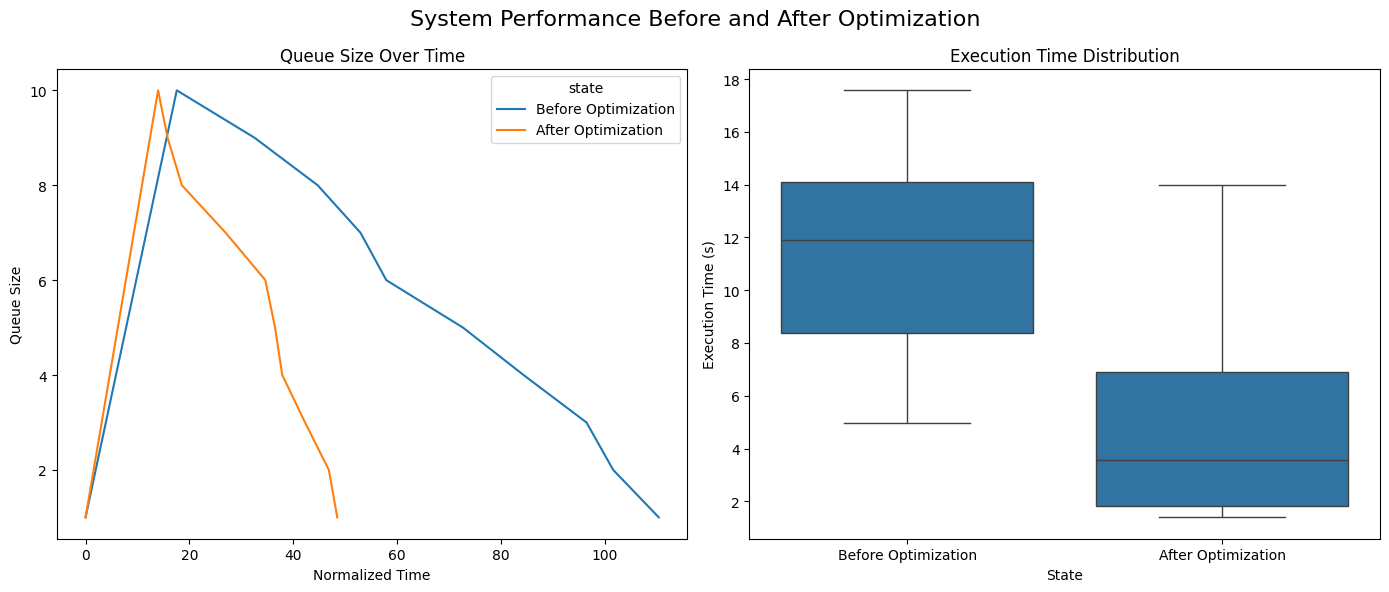

In [ ]:
results_folder = "/content/drive/My Drive/Multilingual Text Summarization Service/optimization_results"
before_optimization_path = os.path.join(results_folder, "before_optimization.csv")
after_optimization_path = os.path.join(results_folder, "after_optimization.csv")

df_before = pd.read_csv(before_optimization_path)
df_before["state"] = "Before Optimization"

df_after = pd.read_csv(after_optimization_path)
df_after["state"] = "After Optimization"

start_time_before = df_before["time"].min()
start_time_after = df_after["time"].min()

df_before["normalized_time"] = df_before["time"] - start_time_before
df_after["normalized_time"] = df_after["time"] - start_time_after

combined_logs = pd.concat([df_before, df_after], ignore_index=True)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle("System Performance Before and After Optimization", fontsize=16)

sns.lineplot(data=combined_logs, x="normalized_time", y="queue_size", hue="state", ax=axes[0])
axes[0].set_title("Queue Size Over Time")
axes[0].set_xlabel("Normalized Time")
axes[0].set_ylabel("Queue Size")

sns.boxplot(data=combined_logs, x="state", y="processing_time", ax=axes[1])
axes[1].set_title("Execution Time Distribution")
axes[1].set_xlabel("State")
axes[1].set_ylabel("Execution Time (s)")

plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.show()